# Combine Deepnet to reinforce the small class's feature

Caffe networks can be transformed to your particular needs by editing the model parameters. The data, diffs, and parameters of a net are all exposed in pycaffe.

Roll up your sleeves for net surgery with pycaffe!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:|
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Load the Designer Net 

To show how to load, manipulate, and save parameters we'll design our own filters into a simple network that's only a single convolution layer. This net has two blobs, `data` for the input and `conv` for the convolution output and one parameter `conv` for the convolution filter weights and biases.

blobs ['data', 'data_data_0_split_0', 'data_data_0_split_1', 'conv1A', 'pool1A', 'norm1A', 'conv2A', 'pool2A', 'norm2A', 'conv3A', 'conv4A', 'conv5A', 'pool5A', 'conv1B', 'pool1B', 'norm1B', 'conv2B', 'pool2B', 'norm2B', 'conv3B', 'conv4B', 'conv5B', 'pool5B', 'concatpool5', 'fc6', 'fc7', 'fc8', 'prob']
params ['conv1A', 'conv2A', 'conv3A', 'conv4A', 'conv5A', 'conv1B', 'conv2B', 'conv3B', 'conv4B', 'conv5B', 'fc6', 'fc7', 'fc8']


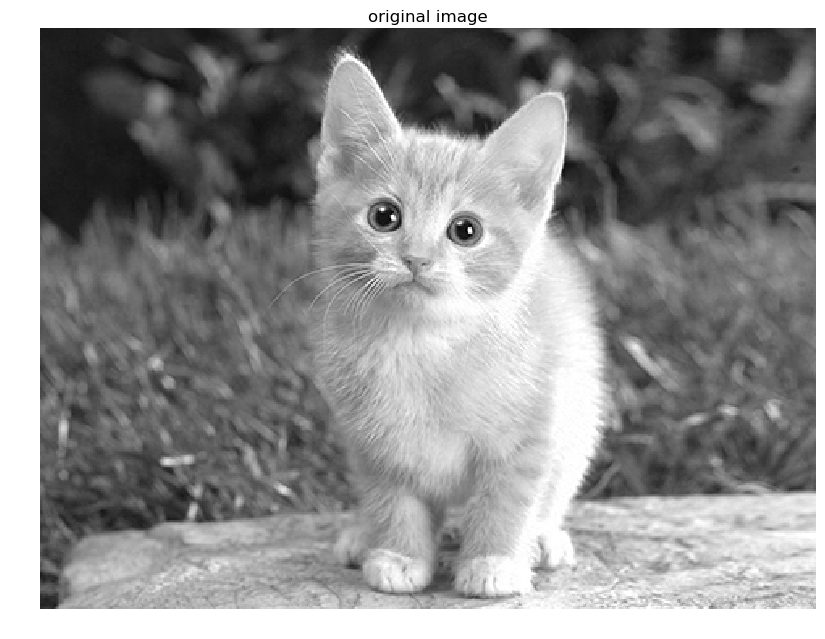

In [3]:
# Load the combined net, list its data and params, and filter an example image.
caffe.set_mode_cpu()
net = caffe.Net('net_surgery/reinforce_bvlc_caffenet_full_conv.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))
# blob for the output of every layers in the net 
# params for the parameters of every layer
# they all saved as a dict

# load image and prepare as a single input batch for Caffe
im = np.array(caffe.io.load_image('images/cat_gray.jpg', color=False)).squeeze()
plt.title("original image")
plt.imshow(im)
plt.axis('off')

im_input = im[np.newaxis, np.newaxis, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

The convolution weights are initialized from Gaussian noise while the biases are initialized to zero. These random filters give output somewhat like edge detections.

Raising the bias of a filter will correspondingly raise its output:

Altering the filter weights is more exciting since we can assign any kernel like Gaussian blur, the Sobel operator for edges, and so on. The following surgery turns the 0th filter into a Gaussian blur and the 1st and 2nd filters into the horizontal and vertical gradient parts of the Sobel operator.

See how the 0th output is blurred, the 1st picks up horizontal edges, and the 2nd picks up vertical edges.

With net surgery, parameters can be transplanted across nets, regularized by custom per-parameter operations, and transformed according to your schemes.

## Casting a Classifier into a Fully Convolutional Network

Let's take the standard Caffe Reference ImageNet model "CaffeNet" and transform it into a fully convolutional net for efficient, dense inference on large inputs. This model generates a classification map that covers a given input size instead of a single classification. In particular a 8 $\times$ 8 classification map on a 451 $\times$ 451 input gives 64x the output in only 3x the time. The computation exploits a natural efficiency of convolutional network (convnet) structure by amortizing the computation of overlapping receptive fields.

To do so we translate the `InnerProduct` matrix multiplication layers of CaffeNet into `Convolutional` layers. This is the only change: the other layer types are agnostic to spatial size. Convolution is translation-invariant, activations are elementwise operations, and so on. The `fc6` inner product when carried out as convolution by `fc6-conv` turns into a 6 $\times$ 6 filter with stride 1 on `pool5`. Back in image space this gives a classification for each 227 $\times$ 227 box with stride 32 in pixels. Remember the equation for output map / receptive field size, output = (input - kernel_size) / stride + 1, and work out the indexing details for a clear understanding.

In [ ]:
!diff net_surgery/reinforce_bvlc_caffenet_full_conv.prototxt ../models/bvlc_reference_caffenet/deploy.prototxt

The only differences needed in the architecture are to change the fully connected classifier inner product layers into convolutional layers with the right filter size -- 6 x 6, since the reference model classifiers take the 36 elements of `pool5` as input -- and stride 1 for dense classification. Note that the layers are renamed so that Caffe does not try to blindly load the old parameters when it maps layer names to the pretrained model.

In [9]:
# Load the original network and extract the needed layers' parameters.
netA = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)

netB = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenetB.caffemodel', 
                caffe.TEST)

paramsA = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
paramsB = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
paramsC = ['fc6', 'fc7', 'fc8']
# fc_params = {name: (weights, biases)}
convA_params = {pr: (netA.params[pr][0].data, netA.params[pr][1].data) for pr in paramsA}
convB_params = {pr: (netB.params[pr][0].data, netB.params[pr][1].data) for pr in paramsB}
fc_params = {pr: (netA.params[pr][0].data, netA.params[pr][1].data) for pr in paramsC}
# to get the detail of the parameters, traverse dict through the key values
# the parameters are storaged in the numpy aray format
print netA.params['conv1'][1].data
# for FC layers, there are two chanels: weights are storaged in net.params['name'][0] and bias in net.params['name']['1'] 
for conv in paramsA:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, convA_params[conv][0].shape, convA_params[conv][1].shape)
for conv in paramsB:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, convB_params[conv][0].shape, convB_params[conv][1].shape)

[-0.50421238 -0.18876393 -0.02636645 -0.28391629 -0.13087654 -0.11392669
 -0.35379818 -0.30511132 -0.29760852 -0.69337481 -0.11503694 -0.61966431
 -0.70348167 -0.36799666 -0.51381624 -0.49909854 -0.39370087 -0.50333488
 -0.49111506 -0.53658897 -0.56017941 -0.76258534 -0.77280825 -0.41975728
  0.03018536 -0.33431506 -0.34035346 -0.02425144 -0.42549044 -0.27354479
 -0.19610897 -0.24530815 -0.21632682 -0.15036488 -0.20419675 -0.34080112
 -0.23292924 -0.39638382 -0.80493212 -0.31510153 -0.58598214 -0.39910233
  0.09619939 -0.08906451 -0.08829892  0.0318777  -0.02993892 -0.6171959
 -0.18537141 -0.53869236 -0.60174769 -0.27657327 -0.50952357 -0.58526754
 -0.63966411 -0.30142948 -0.47553012 -0.43996301 -0.5539273  -0.51534098
 -0.61971736 -0.55452424 -0.40656072 -0.46827394 -0.35246965  0.00648938
 -0.51984924 -0.15539649 -0.5810253  -0.52464545 -0.43813136 -0.07824007
 -0.00753932  0.07540352  0.09931208  0.00120243  0.16252081 -0.24926969
 -0.49946082 -0.26256353 -0.57496488 -0.62123567 -0.

Consider the shapes of the inner product parameters. The weight dimensions are the output and input sizes while the bias dimension is the output size.

In [11]:
# Load the combined convolutional network to transplant the parameters.
net_combine_conv = caffe.Net('net_surgery/reinforce_bvlc_caffenet_full_conv.prototxt', 
                          caffe.TEST)
reinforce_params_convA = ['conv1A', 'conv2A', 'conv3A', 'conv4A', 'conv5A']
reinforce_params_convB = ['conv1B', 'conv2B', 'conv3B', 'conv4B', 'conv5B']
reinforce_params_fc = ['fc6', 'fc7', 'fc8']
# conv_params = {name: (weights, biases)}
combine_conv_paramsA = {pr: (net_combine_conv.params[pr][0].data, net_combine_conv.params[pr][1].data) for pr in reinforce_params_convA}
combine_conv_paramsB = {pr: (net_combine_conv.params[pr][0].data, net_combine_conv.params[pr][1].data) for pr in reinforce_params_convB}
combine_fc_params = {pr: (net_combine_conv.params[pr][0].data, net_combine_conv.params[pr][1].data) for pr in reinforce_params_fc}
for convA in reinforce_params_convA:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(convA, combine_conv_paramsA[convA][0].shape, combine_conv_paramsA[convA][1].shape)
    
for convB in reinforce_params_convB:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(convB, combine_conv_paramsB[convB][0].shape, combine_conv_paramsB[convB][1].shape)    

conv1A weights are (96, 3, 11, 11) dimensional and biases are (96,) dimensional
conv2A weights are (256, 48, 5, 5) dimensional and biases are (256,) dimensional
conv3A weights are (384, 256, 3, 3) dimensional and biases are (384,) dimensional
conv4A weights are (384, 192, 3, 3) dimensional and biases are (384,) dimensional
conv5A weights are (256, 192, 3, 3) dimensional and biases are (256,) dimensional
conv1B weights are (96, 3, 11, 11) dimensional and biases are (96,) dimensional
conv2B weights are (256, 48, 5, 5) dimensional and biases are (256,) dimensional
conv3B weights are (384, 256, 3, 3) dimensional and biases are (384,) dimensional
conv4B weights are (384, 192, 3, 3) dimensional and biases are (384,) dimensional
conv5B weights are (256, 192, 3, 3) dimensional and biases are (256,) dimensional


The convolution weights are arranged in output $\times$ input $\times$ height $\times$ width dimensions. To map the inner product weights to convolution filters, we could roll the flat inner product vectors into channel $\times$ height $\times$ width filter matrices, but actually these are identical in memory (as row major arrays) so we can assign them directly.

The biases are identical to those of the inner product.

Let's transplant!

In [7]:
for pr_convA, pr_convB, pr_c_convA, pr_c_convB in zip(paramsA, paramsB, reinforce_params_convA, reinforce_params_convB):
    print pr_convA
    print pr_convB
    print pr_c_convA
    print pr_c_convB

conv1
conv1
conv1A
conv1B
conv2
conv2
conv2A
conv2B
conv3
conv3
conv3A
conv3B
conv4
conv4
conv4A
conv4B
conv5
conv5
conv5A
conv5B


In [13]:
for pr_convA, pr_convB, pr_c_convA, pr_c_convB in zip(paramsA, paramsB, reinforce_params_convA, reinforce_params_convB):
    
    combine_conv_paramsA[pr_c_convA][0].flat = convA_params[pr_convA][0].flat  # flat unrolls the arrays
    combine_conv_paramsA[pr_c_convA][1][...] = convA_params[pr_convA][1][...] 
    combine_conv_paramsB[pr_c_convB][0].flat = convB_params[pr_convB][0].flat  # flat unrolls the arrays
    combine_conv_paramsB[pr_c_convB][1][...] = convB_params[pr_convB][1][...] 

In [14]:
for pr, pr_combine in zip(paramsC, reinforce_params_fc):
    combine_fc_params[pr_combine][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    combine_fc_params[pr_combine][1][...] = fc_params[pr][1]

Next, save the new model weights.

In [15]:
net_combine_conv.save('net_surgery/bvlc_caffenet_combine.caffemodel')

In [16]:
combine_net = caffe.Net('net_surgery/reinforce_bvlc_caffenet_full_conv.prototxt', 
                'net_surgery/bvlc_caffenet_combine.caffemodel', 
                caffe.TEST)
print("blobs {}\nparams {}".format(combine_net.blobs.keys(), combine_net.params.keys()))
print combine_net.params['fc6'][1].data

blobs ['data', 'data_data_0_split_0', 'data_data_0_split_1', 'conv1A', 'pool1A', 'norm1A', 'conv2A', 'pool2A', 'norm2A', 'conv3A', 'conv4A', 'conv5A', 'pool5A', 'conv1B', 'pool1B', 'norm1B', 'conv2B', 'pool2B', 'norm2B', 'conv3B', 'conv4B', 'conv5B', 'pool5B', 'concatpool5', 'fc6', 'fc7', 'fc8', 'prob']
params ['conv1A', 'conv2A', 'conv3A', 'conv4A', 'conv5A', 'conv1B', 'conv2B', 'conv3B', 'conv4B', 'conv5B', 'fc6', 'fc7', 'fc8']
[ 0.98369783  1.00961924  0.99359578 ...,  0.96961963  0.98051935
  1.01731122]


To conclude, let's make a classification map from the example cat image and visualize the confidence of "tiger cat" as a probability heatmap. This gives an 8-by-8 prediction on overlapping regions of the 451 $\times$ 451 input.

0


TypeError: Invalid dimensions for image data

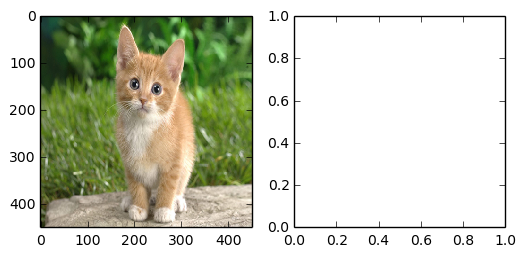

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_combine_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_combine_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_combine_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0,281])

The classifications include various cats -- 282 = tiger cat, 281 = tabby, 283 = persian -- and foxes and other mammals.

In this way the fully connected layers can be extracted as dense features across an image (see `net_full_conv.blobs['fc6'].data` for instance), which is perhaps more useful than the classification map itself.

Note that this model isn't totally appropriate for sliding-window detection since it was trained for whole-image classification. Nevertheless it can work just fine. Sliding-window training and finetuning can be done by defining a sliding-window ground truth and loss such that a loss map is made for every location and solving as usual. (This is an exercise for the reader.)

*A thank you to Rowland Depp for first suggesting this trick.*